In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from tabulate import tabulate

houses_colors = {'Gryffindor': '#7F0909', 'Slytherin': '#0D6217', 'Hufflepuff': '#EEE117', 'Ravenclaw': '#000A90'}

In [2]:
def warn_diff(feature, val_type, standard_val, local_val):
    print("DIFF FOR: [%s] [%s] [%f] [%f]" % (feature, val_type, standard_val, local_val))

In [3]:
def trim_dataframe(df):
    # Drop empty columns
    df.dropna(axis=1, how='all', inplace=True)

    # Retrieve only columns with numeric values
    df = df._get_numeric_data()

    # Drop nan values from features
    for feature in df.keys():
        df[feature].dropna(inplace=True)
    
    return df

In [4]:
def my_count(values):
    count = 0.0
    for value in values:
        count += 1
    return count

In [5]:
def my_sum(values):
    s = 0
    for value in values:
        s += value
    return s

In [6]:
def my_mean(values, count=None):
    if count is None:
        count = my_count(values)
    if count > 0:
        return (my_sum(values) / count)
    else:
        print("Error in my_mean: counted [%f] elements in values" % (count))
        return None

In [7]:
# We set count default value as None so that if feature has already been counted, we can just pass it as a parameter instead of calculating again in the 
# function, but the function still keeps the ability to count the feature
def my_std(values, mean, ddof=1, count=None):
    total = 0.0
    if count is None:
        count = my_count(values)
    if count > 0:
        for value in values:
            total += abs(value - mean)**2
        std = np.sqrt(total / (count - ddof))
        return std
    else:
        print("Error in my_std: counted [%f] elements in values" % (count))
        return None

In [8]:
def my_min(values):
    m = values[0]
    for value in values:
        if value < m:
            m = value
    return m

In [9]:
def my_max(values):
    m = values[0]
    for value in values:
        if value > m:
            m = value
    return m

In [10]:
# Pure-Python implementation of percentile function: https://stackoverflow.com/a/2753343
def my_quantile(values, quantile, count=None):
    duplicate = values.copy()
    duplicate.sort_values(inplace=True)
    if count is None:
        count = my_count(values)
    if count > 0:
        k = (count -1) * quantile
        f = math.floor(k)
        c = math.ceil(k)
        if f == c:
            return (duplicate.iloc[int(k)])
        d0 = duplicate.iloc[int(f)] * (c-k)
        d1 = duplicate.iloc[int(c)] * (k-f)
        return d0+d1
    else:
        print("Error in my_quantile: counted [%f] elements in values" % (count))

In [11]:
def read_file(filename):
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print("File not found, exiting program")
    except OSError:
        print("OSError raised reading the file, exiting program")
    except pd.errors.ParserError:
        print("Invalid file, exiting program")
    else:
        return df
    exit(1)

In [12]:
def format_output(describe):
    # Returning a dict with the same structure as the pandas describe function
    out = {}
    out[""] = []
    for val_type in describe[next(iter(describe))]:
        out[""].append(val_type)
    for feature in describe.keys():
        out[feature] = []
        for val_type in out[""]:
            out[feature].append(describe[feature][val_type])
    return out

In [13]:
def my_describe(df, df_orig, print_describe=True):
    # "Delta Degrees of Freedom" - Not exactly sure of what it does with such dataframes
    ddof = 1

    # Values calculated with our functions go to describe dict
    describe = {}
    # Values calculated with system/numpy functions go to control_values dict
    # It will allow us to check if our functions return correct values
    control_values = df_orig.describe()
    for feature in df:
        describe[feature] = {}
        describe[feature]["count"] = my_count(df[feature])
        describe[feature]["mean"] = my_mean(df[feature], count=describe[feature]["count"])
        describe[feature]["std"] = my_std(df[feature], describe[feature]["mean"], ddof=ddof, count=describe[feature]["count"])
        describe[feature]["min"] = my_min(df[feature])
        describe[feature]["25%"] = my_quantile(df[feature], .25, count=describe[feature]["count"])
        describe[feature]["50%"] = my_quantile(df[feature], .5, count=describe[feature]["count"])
        describe[feature]["75%"] = my_quantile(df[feature], .75, count=describe[feature]["count"])
        describe[feature]["max"] = my_max(df[feature])

        # For each significative difference between results from our functions and results from system/numpy functions, we output a warning
        for value in control_values[feature].keys():
            if not np.isclose(describe[feature][value], control_values[feature][value]):
                warn_diff(feature, value, describe[feature][value], control_values[feature][value])
    
    if print_describe is True:
        print(tabulate(format_output(describe), headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))
        print(tabulate(df_orig.describe(), headers="keys", tablefmt="fancy_grid", floatfmt=".6f"))
    
    return describe


In [14]:
def get_value(describe, value_name):
    values = {}
    for feature in describe:
        for value in describe[feature].keys():
            if value == value_name:
                values[feature] = describe[feature][value]
    return values

In [15]:
def normalize(values):
    norm_values = {}
    
    min_value = my_min(list(values.values()))
    max_value = my_max(list(values.values()))
    for feature in values.keys():
        norm_values[feature] = float((values[feature] - min_value) / (max_value - min_value))

    return norm_values

In [16]:
def my_histogram(df, df_orig, describe=None):
    if describe is None:
        describe = my_describe(df, df_orig, print_describe=False)
    
    std = get_value(describe, "std")
    
    #normalized_std = normalize(std)
    #print(normalized_std)
    
    fig = go.Figure()
    for feature in std:
        fig.add_trace(go.Histogram(histfunc="avg", x=[feature], y=[std[feature]], name=feature, opacity=0.8))
    fig.update_layout(title="Variances between the student's grades for each feature (less variance means that the student's grades are homogeneous)", xaxis_title="Feature", yaxis_title="Variance")

    fig.show()

In [17]:
def pair_plot(df, df_orig, use_houses_colors=False):
    graph = sns.pairplot(
        df_orig,
        hue="Hogwarts House",
        vars=df,
        plot_kws={'alpha':0.2},
        diag_kind='hist',
        diag_kws={'alpha':0.6},
        palette=houses_colors
    )
    plt.show()

╒═══════╤═════════════╤═══════════════╤═════════════╤═════════════╤═════════════════════════════════╤══════════════╤══════════════════╤═════════════════╤════════════════════╤═══════════════════╤═════════════╤═════════════════════════════╤═════════════╤═════════════╕
│       │       Index │    Arithmancy │   Astronomy │   Herbology │   Defense Against the Dark Arts │   Divination │   Muggle Studies │   Ancient Runes │   History of Magic │   Transfiguration │     Potions │   Care of Magical Creatures │      Charms │      Flying │
╞═══════╪═════════════╪═══════════════╪═════════════╪═════════════╪═════════════════════════════════╪══════════════╪══════════════════╪═════════════════╪════════════════════╪═══════════════════╪═════════════╪═════════════════════════════╪═════════════╪═════════════╡
│ count │ 1600.000000 │   1566.000000 │ 1568.000000 │ 1567.000000 │                     1569.000000 │  1561.000000 │      1565.000000 │     1565.000000 │        1557.000000 │       1566.000000 │ 1570

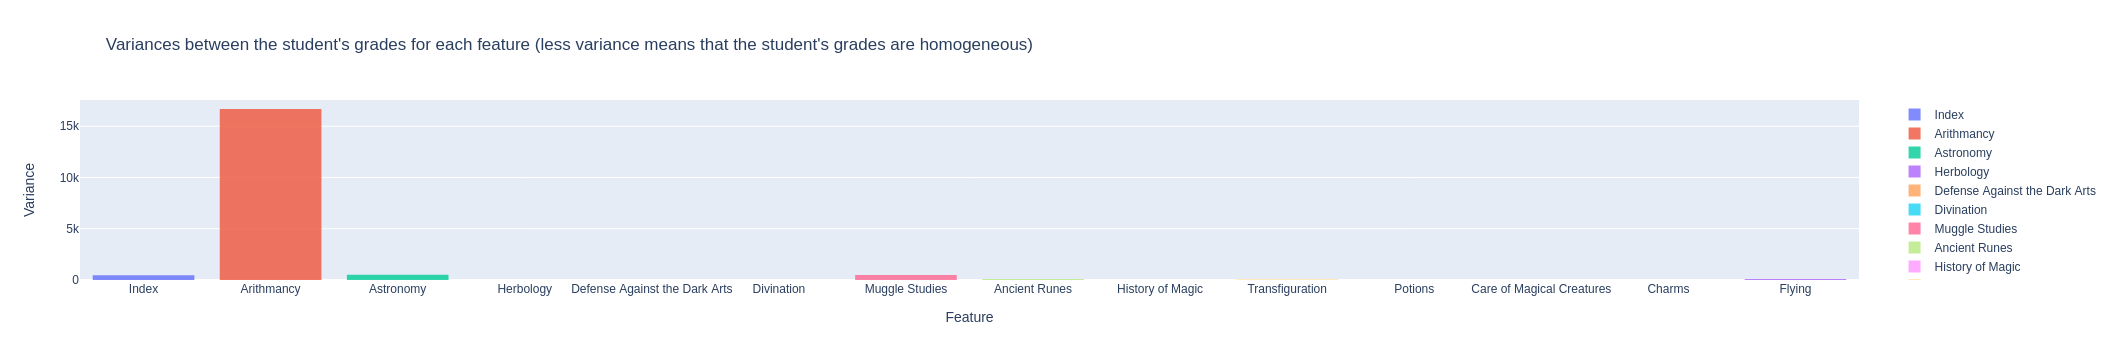

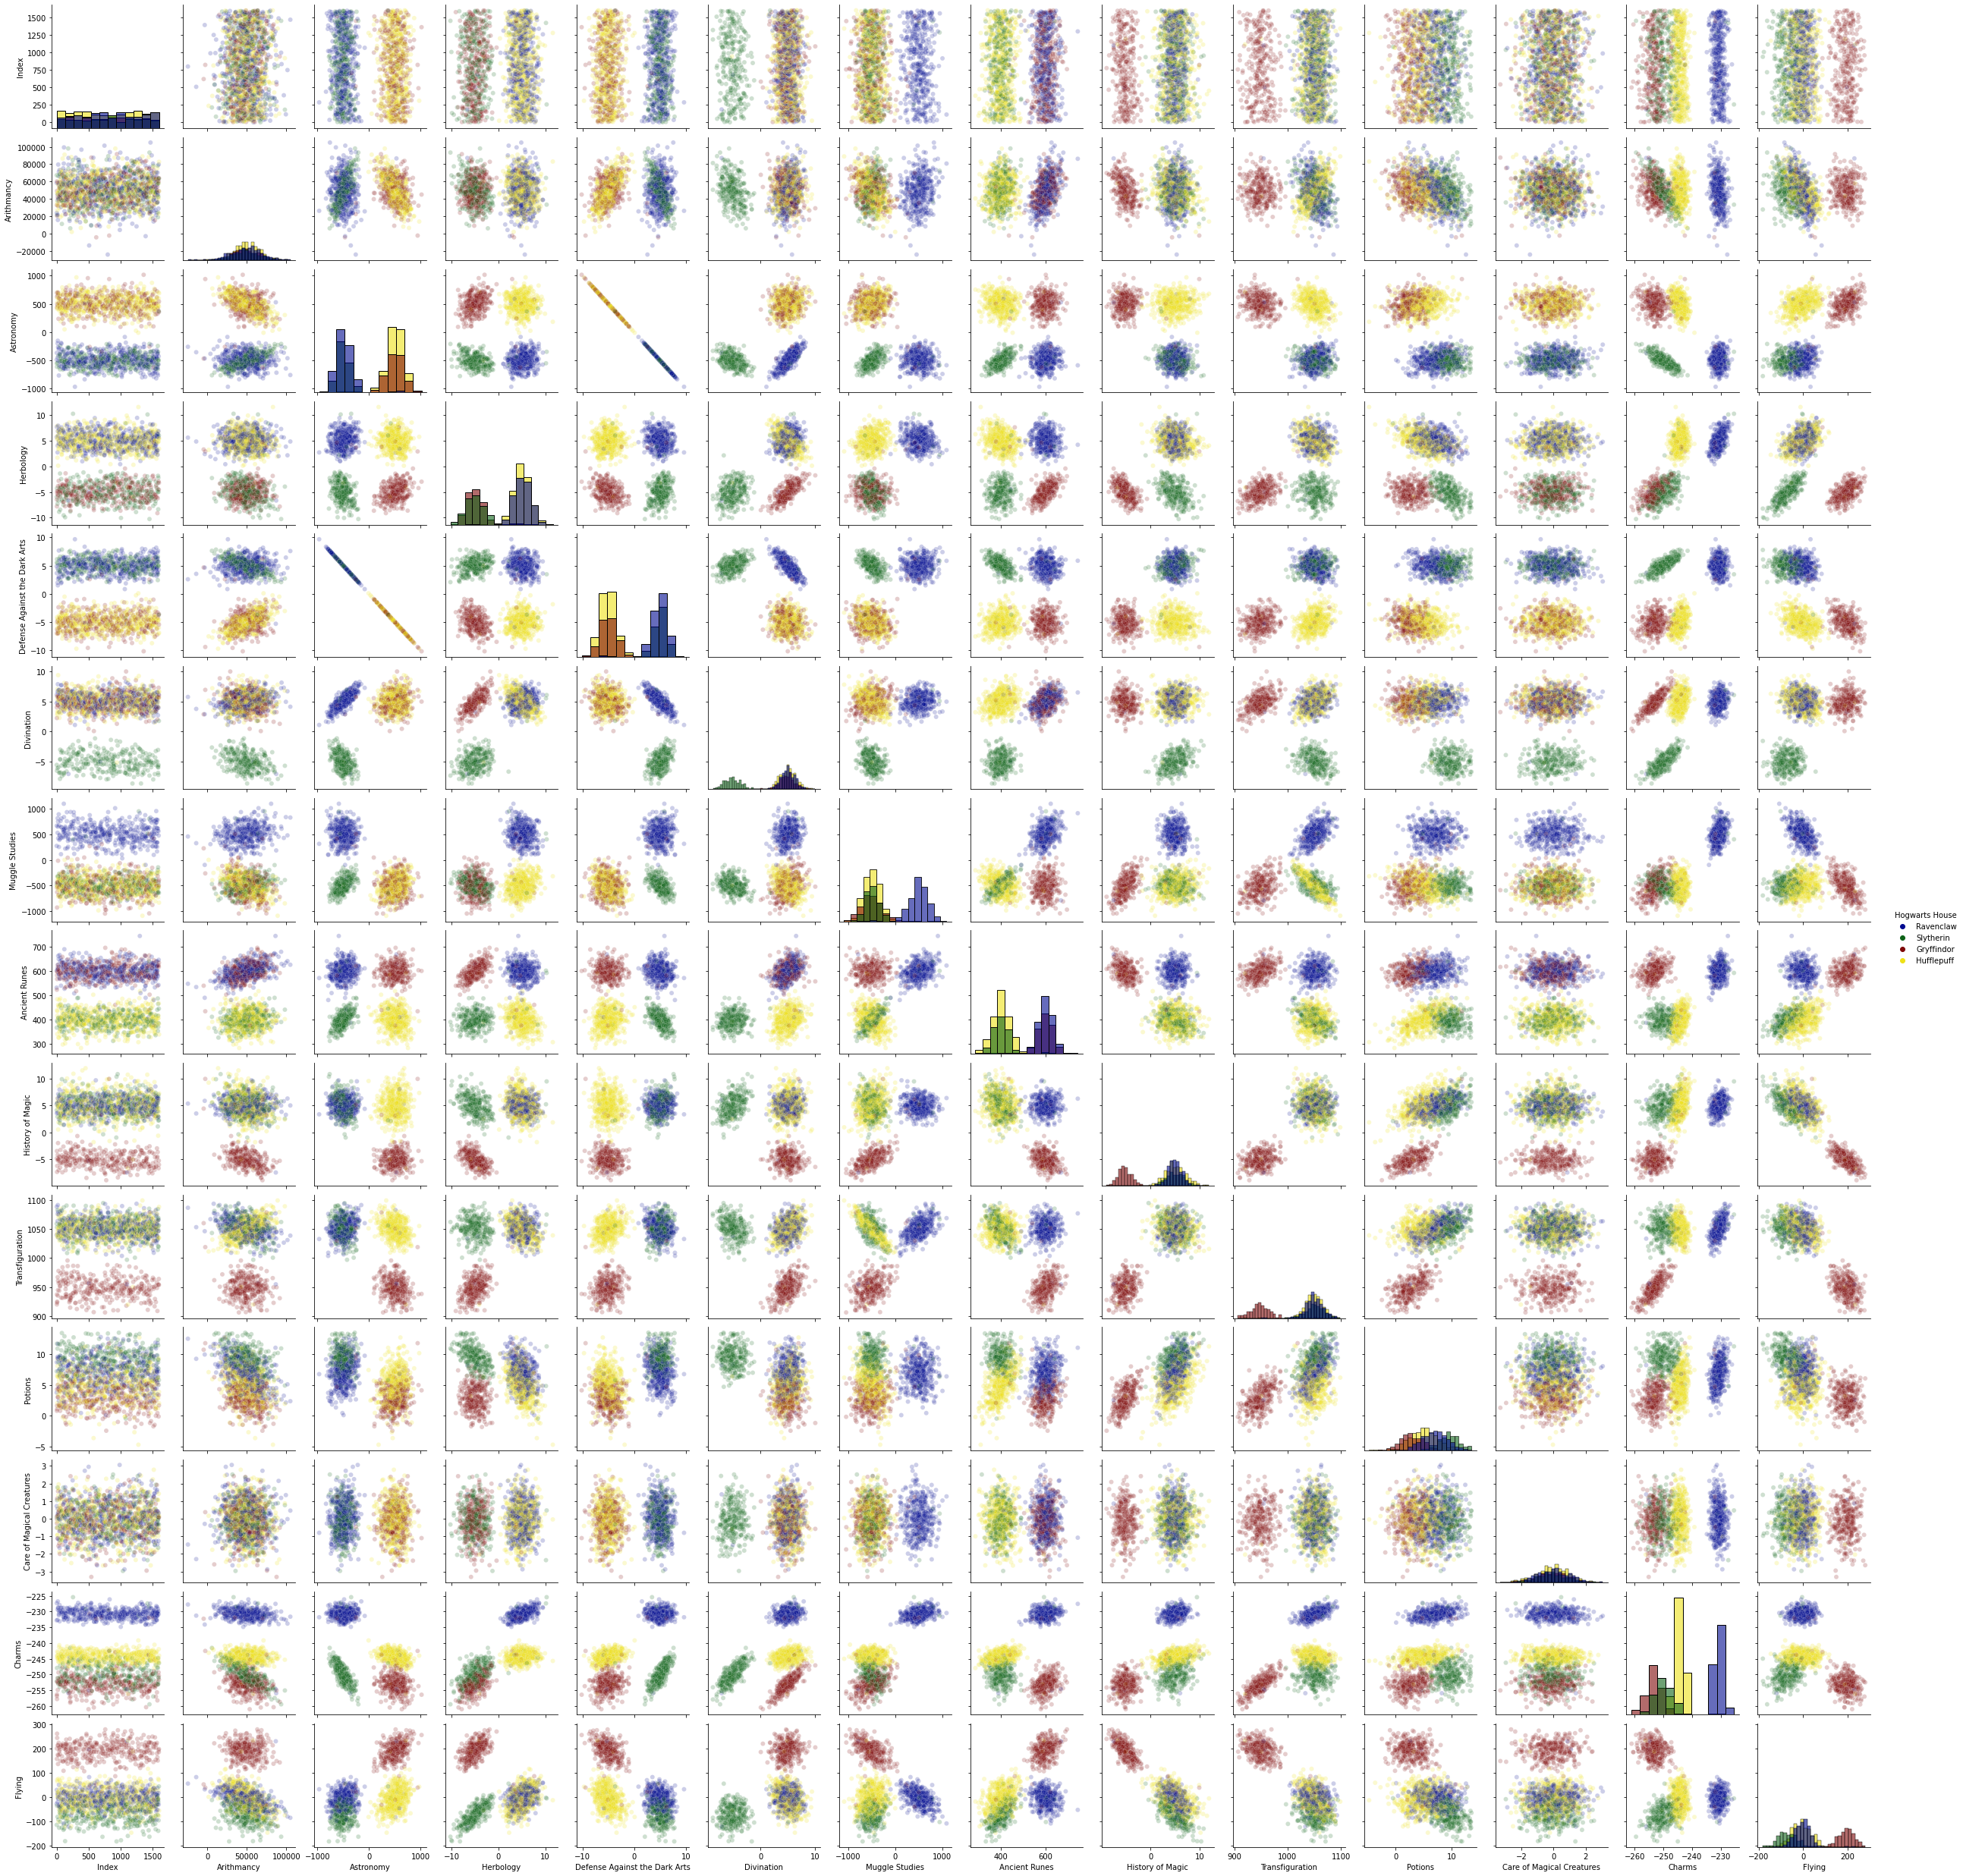

In [18]:
# Read CSV file with pandas
df_orig = read_file("datasets/dataset_train.csv")

# Trim the dataframe to avoid nans and keep only the numeric values that will be used in calculations
df = trim_dataframe(df_orig.copy())

# Describe
desc = my_describe(df, df_orig)

# Plotting the dataset
my_histogram(df, df_orig)

pair_plot(df, df_orig, use_houses_colors=True)